# In-class exercise 8: PyTorch from the bottom up

Based on Jeremy Howard's PyTorch tutorial "What is torch.nn really?"

In this tutorial we will start at [PyTorch](https://pytorch.org/docs)'s lowest layer and then gradually introduce functions and features until we arrive at `nn.Sequential`. Lower layers give you more control over what you want to do, while higher layers allow for faster implementations. So in practice you have to choose at which layer you want to work. Moreover, knowing how the lower layers work will give you a better understanding of what is happening behind the scenes when working with the higher level abstractions.

In [35]:
import copy
import math
import random
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from beartype import beartype
from jaxtyping import Float
from torch import Tensor
from torchvision.transforms import v2

A quick example:
To make our code more clean and readable, we make use of **type annotations**. These are not necessary, but can be very helpful when working with Python and PyTorch. We also use the `beartype` decorator to make sure that our code is type-checked.

In [38]:
@beartype
def sum(x: int, y: int | float) -> int | float:
    return x + y

In [40]:
a = sum(1, 2)
a

3

In [46]:
b = sum(1, 1.2)
b

2.2

# Download the data
In this tutorial we will be working with the **MNIST dataset**. This is a classic dataset consisting of gray-scale images of hand-drawn digits.

We will use [torchvision](https://pytorch.org/vision/stable/index.html) to download the dataset. Torchvision also provides a lot of functionality for data preprocessing and augmentation, which is beyond the scope of this tutorial.

In [23]:
# download MNIST dataset
mnist_train = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_test = torchvision.datasets.MNIST("./data", train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:02<00:00, 4.50MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 286kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.80MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 5.47MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



MNIST consists of 70,000 28x28 images, each corresponding to a single digit (0 to 9), divided into 60,000 training images and 10,000 test images.

In [25]:
mnist_train, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test)

The MNIST dataset provided by torchvision is a subclass of `torch.utils.data.Dataset`. This is a PyTorch class that allows you to easily load and process data. It is a very useful class that you will use a lot when working with PyTorch.

The input data $\mathbf{X}$ and targets $\mathbf{y}$ are saved in `data` and `targets`, so we will at first just extract these and work with the raw data.

In [29]:
imgs, labels = mnist_train.data, mnist_train.targets
imgs = imgs.unsqueeze(dim=1)

In [31]:
print(imgs.shape, imgs.dtype, imgs.min(), imgs.max())
print(labels.shape, labels.dtype, labels.min(), labels.max())

torch.Size([60000, 1, 28, 28]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
torch.Size([60000]) torch.int64 tensor(0) tensor(9)


Let's have a look at the first 10 images in the dataset.

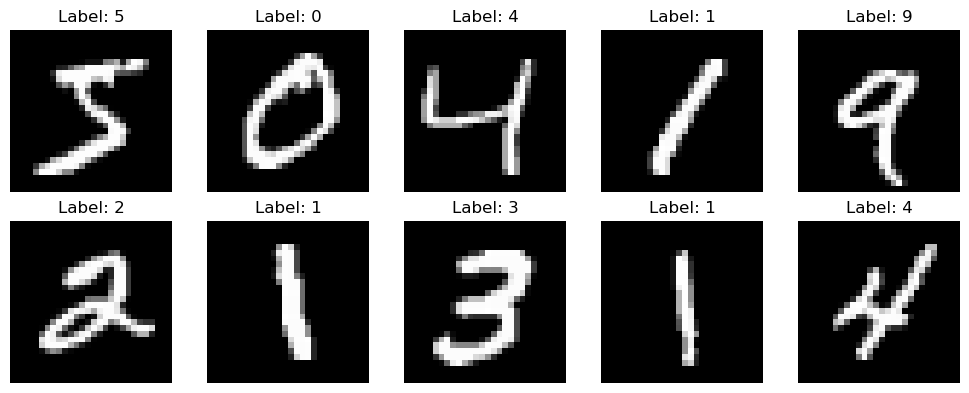

In [48]:
# plot the first 10 images
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    ax[i // 5, i % 5].imshow(imgs[i, 0], cmap="gray")
    ax[i // 5, i % 5].set_title(f"Label: {labels[i]}")
    ax[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

We convert them to values between 0 and 1.

In [51]:
imgs = imgs / 255.0

Note that setting `train=True` gives you the development set, i.e. both training and validation data. So we need to **split** this further into a training and validation set.

In [54]:
# split the dataset into train and validation
NUM_TRAIN = 50_000

x_train, y_train = imgs[:NUM_TRAIN], labels[:NUM_TRAIN]
x_val, y_val = imgs[NUM_TRAIN:], labels[NUM_TRAIN:]

Let us define the test set as well.

In [57]:
x_test = (mnist_test.data / 255.0)
y_test = mnist_test.targets

Let's have a final check to sizes, dtypes, etc. of the data.

In [60]:
# check the shapes and data types
print(
    f"Training data: {x_train.shape}, {y_train.shape}, {x_train.dtype}, {y_train.dtype}"
)
print(f"Validation data: {x_val.shape}, {y_val.shape}, {x_val.dtype}, {y_val.dtype}")
print(f"Test data: {x_test.shape}, {y_test.shape}, {x_test.dtype}, {y_test.dtype}")

Training data: torch.Size([50000, 1, 28, 28]), torch.Size([50000]), torch.float32, torch.int64
Validation data: torch.Size([10000, 1, 28, 28]), torch.Size([10000]), torch.float32, torch.int64
Test data: torch.Size([10000, 28, 28]), torch.Size([10000]), torch.float32, torch.int64


We save the number of features and the number of classes in variables, so that we can use them later.

In [63]:
# define number of features and classes
NUM_FEATURES = math.prod(x_train.shape[1:])
NUM_CLASSES = len(torch.unique(y_train))

print(f"Num. of features: {NUM_FEATURES}")
print(f"Num. of classes: {NUM_CLASSES}")

Num. of features: 784
Num. of classes: 10


## Reproducibility

Reproducibility is important in machine learning. If you run the same code twice, you should get the same results. This is not always the case, because of the randomness involved in the training process. For example, if you initialize the weights of a neural network randomly, you will get different results each time you run the code. This is not a problem if you only run the code once, but if you want to compare different models, you need to make sure that the results are reproducible.

In PyTorch, you can set the random seed using `torch.manual_seed()`. This will make sure that the results are reproducible. For custom operators, you might need to set python seed as well as the numpy random generator seed, using `random.seed()` and `np.random.seed()`.

However, this is not enough. You also need to make sure that the results are reproducible on the GPU. This goes beyond the scope of this tutorial, but you can find more information [here](https://pytorch.org/docs/stable/notes/randomness.html).

**TL;DR**: reproducibility is crucial, and hard to achieve (especially on the GPU). If you want to compare different models, you need to make sure that the results are reproducible.

In [66]:
@beartype
def set_seed(seed: int) -> None:
    """Set the random seed for reproducibility.

    Args:
        seed: the random seed
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [68]:
# Show how seed affects the random number generation
print(f"Seed: 42")
set_seed(42)
print(np.random.randint(0, 100, 6))
print(np.random.randint(0, 100, 6))
set_seed(42)
print(f"Seed: 42")
print(np.random.randint(0, 100, 3))
print(np.random.randint(0, 100, 3))
print(np.random.randint(0, 100, 3))
print(np.random.randint(0, 100, 3))

Seed: 42
[51 92 14 71 60 20]
[82 86 74 74 87 99]
Seed: 42
[51 92 14]
[71 60 20]
[82 86 74]
[74 87 99]


In [70]:
SEED = 42
set_seed(SEED)

# torch.tensor
PyTorch uses its own `torch.tensor` datatype. This is very similar to a Numpy Array, but can also be moved to and used for calculations on a GPU, and supports storing gradient information and hence dynamic backpropagation.

The special function `requires_grad` allows us to specify whether we want to store gradient information for a tensor. This is useful when we want to use the tensor in a neural network, and we want to calculate the gradients of the loss function with respect to the tensor.

In [82]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=False)
y = torch.tensor([4.0, 5.0, 6.0], requires_grad=False)
z = torch.tensor([7.0, 8.0, 9.0], requires_grad=True)

a = x + y
b = x + z

print(f"a.requires_grad: {a.requires_grad}")
print(f"b.requires_grad: {b.requires_grad}")

b

a.requires_grad: False
b.requires_grad: True


tensor([ 8., 10., 12.], grad_fn=<AddBackward0>)

# Affine layer

We start by manually setting up an **affine layer**.

$$
\mathbf{y} = \mathbf{W} \mathbf{x} + \mathbf{b}
$$

Let's define some weights and biases (without caring about the initialization for now).

For this we use the `torch.empty` function, which creates an uninitialized tensor of the given size. (Note that `torch.empty` does not return an empty tensor, but an uninitialized tensor. This is a bit confusing, but it is what it is). Similarly one can use `Tensor`, which is a special case of `torch.empty` (see [here](https://stackoverflow.com/questions/51129043/whats-the-difference-between-torch-tensor-vs-torch-empty-in-pytorch)).

Note that we do not want to store gradient information for the weights and biases as of now. We will do this after we have initialized them.

In [100]:
imgs[10].shape
math.prod(imgs[10].shape)

784

In [102]:
weight = torch.empty(NUM_FEATURES, NUM_CLASSES, requires_grad=False)
bias = torch.empty(NUM_CLASSES, requires_grad=False)

weight, bias

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

We can now initialize the weights via **Xavier (Glorot) initialization**. Appending a function with `_` (e.g., `requires_grad_`) means that the function is applied in-place.

In [109]:
@beartype
def sample_from_uniform(
    *size: tuple[int] | int, low: float = -1.0, high: float = 1.0
) -> Tensor:
    """Sample from uniform distribution.

    Args:
        size: the size of the output tensor
        low: the lower bound of the uniform distribution. Defaults to -1.0.
        high: the upper bound of the uniform distribution. Defaults to 1.0.

    Returns:
        the output tensor sampled from uniform distribution
    """
    # torch.rand generates samples from uniform distribution [0, 1)
    # multiply by (high - low) to get samples from uniform distribution [0, high-low)
    # shift the distribution by adding low to get samples from uniform distribution [low, high)
    return torch.rand(*size, dtype=torch.float32) * (high - low) + low


@beartype
def xavier_uniform_init(weight: Tensor, requires_grad: bool = True) -> Tensor:
    """Initialize weight using Xavier uniform initialization.

    Args:
        weight: the weight tensor
        requires_grad: whether the weight tensor requires gradient. Defaults to True.

    Returns:
        the weight tensor initialized using Xavier uniform initialization
    """
    fan_in, fan_out = weight.shape
    bound = np.sqrt(6 / (fan_in + fan_out))
    out = sample_from_uniform(fan_in, fan_out, low=-bound, high=bound)
    if requires_grad:
        out.requires_grad_()
    return out


@beartype
def zeros_init(weight: Tensor, requires_grad: bool = True) -> Tensor:
    """Initialize weight using zeros.

    Args:
        weight: the weight tensor
        requires_grad: whether the weight tensor requires gradient. Defaults to True.

    Returns:
        the weight tensor initialized using zeros
    """
    return torch.zeros_like(weight, requires_grad=requires_grad)

In [111]:
# initialize weight using Glorot initialization and bias to zero
weight = xavier_uniform_init(weight, requires_grad=True)
bias = zeros_init(bias, requires_grad=True)

weight, bias

(tensor([[-0.0227,  0.0688, -0.0079,  ..., -0.0300,  0.0044,  0.0397],
         [ 0.0169, -0.0189,  0.0006,  ..., -0.0292,  0.0555,  0.0783],
         [-0.0411,  0.0369, -0.0204,  ..., -0.0033,  0.0256, -0.0512],
         ...,
         [-0.0308,  0.0823,  0.0327,  ..., -0.0087, -0.0288,  0.0409],
         [-0.0313, -0.0636,  0.0604,  ..., -0.0476,  0.0037, -0.0103],
         [ 0.0259, -0.0674, -0.0767,  ...,  0.0169, -0.0018, -0.0427]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

The weights and biases are now initialized, and they now require gradient information.

We now use these weights to create a **simple linear model** (i.e. logistic regression).

In [113]:
@beartype
def model(x: Float[Tensor, "batch channels height width"], weight: Tensor, bias: Tensor) -> Float[Tensor, "batch classes"]:
    """Compute the logits of the model.

    Args:
        x: the input tensor
        weight: the weight tensor
        bias: the bias tensor

    Returns:
        the logits of the model
    """
    return x.flatten(start_dim=1) @ weight + bias

We furthermore define a loss (negative log-likelihood) for training and a function to obtain the prediction accuracy.



In [116]:
@beartype
def log_softmax(x: Tensor) -> Tensor:
    """Compute the log softmax of the input tensor.

    Args:
        x: the input tensor

    Returns:
        the log softmax of the input tensor
    """
    return x - x.exp().sum(-1).log().unsqueeze(-1)


@beartype
def nll_loss(logits: Tensor, target: Tensor) -> Tensor:
    """Compute the negative log likelihood loss.

    Args:
        logits: the logits of the model
        target: the target tensor

    Returns:
        the negative log likelihood loss
    """
    output = log_softmax(logits)
    return -output[range(target.shape[0]), target].mean()

We can now use our model to make predictions. Let's see how it performs without training.

In [118]:
x, label = x_train[:64], y_train[:64]
logits = model(x, weight, bias)
print(logits.shape)
loss = nll_loss(logits, label)

torch.Size([64, 10])


# Training loop

We can now define a training loop. In this loop we need to
1. Get a mini-batch of data. When using dynamic computation graphs like in PyTorch it is important to choose a batch size that is large enough to leverage your hardware properly.
2. Generate predictions with our model
3. Calculate the loss
4. Update the gradients via `loss.backward()`
5. Update the `weight` and `bias` based on the gradients (optimization)

In [120]:
# define loss function
criterion = nll_loss

# define hyperparameters
LEARNING_RATE = 0.01
NUM_EPOCHS = 5
BATCH_SIZE = 64


@beartype
def fit(
    model: Callable,
    weight: Tensor,
    bias: Tensor,
    x_train: Tensor,
    y_train: Tensor,
    criterion: Callable,
    learning_rate: float,
    num_epochs: int,
    batch_size: int,
) -> None:
    """Train the model.

    Args:
        model: a callable that returns the logits given the input and the parameters
        weight: the weight tensor
        bias: the bias tensor
        x_train: the training features tensor
        y_train: the training labels tensor
        criterion: a callable that returns the loss given the logits and the labels
        learning_rate: the learning rate
        num_epochs: the number of epochs
        batch_size: the batch size
    """
    # Compute number of batches
    num_train = x_train.shape[0]
    num_batches = int(np.ceil(num_train / batch_size))

    # Initialize loss and accuracy history
    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        epoch_acc = 0.0

        for i in range(num_batches):
            # Get mini-batch
            start_i = i * batch_size
            end_i = min(start_i + batch_size, num_train)
            x_batch, y_batch = x_train[start_i:end_i], y_train[start_i:end_i]

            # Generate predictions
            pred = model(x_batch, weight, bias)

            # Calculate loss
            loss = criterion(pred, y_batch)

            # Zero out the gradients
            if weight.grad is not None:
                weight.grad.zero_()
            if bias.grad is not None:
                bias.grad.zero_()

            # Compute gradients
            loss.backward()

            # Update parameters
            with (
                torch.inference_mode()
            ):  # "new version" of torch.no_grad() (potentially faster)
                weight -= learning_rate * weight.grad
                bias -= learning_rate * bias.grad

            # Accumulate loss and accuracy
            epoch_loss += loss.item()
            top1 = pred.argmax(-1) == y_batch
            ncorrect = torch.sum(top1).item()
            epoch_acc += ncorrect

        # Epoch loss and accuracy
        epoch_loss /= num_train
        epoch_acc /= num_train

        # Print progress
        print(
            f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}"
        )

        # Record loss and accuracy
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

    # Plot loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(loss_history)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax2.plot(acc_history)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    fig.suptitle(f"Training")
    plt.show()

Epoch 1/5 | Loss: 0.0169 | Acc: 0.7425
Epoch 2/5 | Loss: 0.0094 | Acc: 0.8558
Epoch 3/5 | Loss: 0.0079 | Acc: 0.8711
Epoch 4/5 | Loss: 0.0072 | Acc: 0.8797
Epoch 5/5 | Loss: 0.0068 | Acc: 0.8848


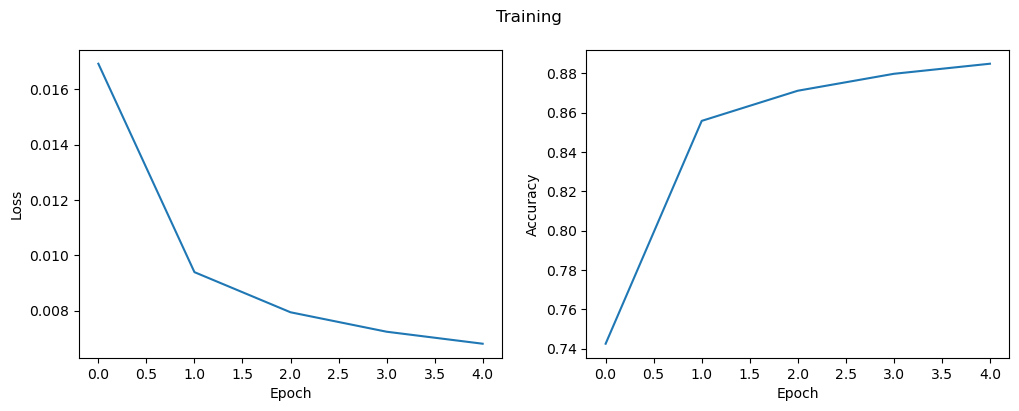

In [122]:
fit(
    model,
    weight,
    bias,
    x_train,
    y_train,
    criterion,
    LEARNING_RATE,
    NUM_EPOCHS,
    BATCH_SIZE,
)

Nice, it works! Wasn't this already way easier than with pure Numpy? But this is just the start. Now that we've implemented our model in the lowest level of PyTorch we can start to go up the ladder and make this even better and simpler!

# torch.nn.functional

We will start by replacing some of our hand-written functions with their professionally implemented counterparts in `torch.nn.functional`. This library contains all of the PyTorch functions (other parts contain the classes). It is commonly imported via

In [124]:
import torch.nn.functional as F

Instead of using `log_softmax` and `neg_loglikelihood` we can instead just use `F.cross_entropy`, which combines both of these.

The loss should still be the same.

In [126]:
criterion = nll_loss
pred = model(x_train[:BATCH_SIZE], weight, bias)
target = y_train[:BATCH_SIZE]
print(criterion(pred, target))

criterion = F.cross_entropy
pred = model(x_train[:BATCH_SIZE], weight, bias)
target = y_train[:BATCH_SIZE]
print(criterion(pred, target))

tensor(0.4013, grad_fn=<NegBackward0>)
tensor(0.4013, grad_fn=<NllLossBackward0>)


# nn.Module
Next we will use `nn.Module` and `nn.Parameter` for a clearer and more concise model definition and training loop. By subclassing `nn.Module` we obtain various convenience functions such as `.parameters()` and `.zero_grad()`.

In [128]:
from torch import nn


@beartype
class LogisticRegression(nn.Module):
    """Logistic regression model.

    The model consists of a single linear layer that maps from the number of features to the number of classes.
    """

    def __init__(self, num_features: int, num_classes: int) -> None:
        """Constructor method for LogisticRegression.

        Args:
            num_features: the number of features
            num_classes: the number of classes
        """
        super().__init__()

        # define the parameters
        self.weight = nn.Parameter(Tensor(num_features, num_classes))
        self.bias = nn.Parameter(Tensor(num_classes))

        # initialize the parameters
        self.init_weights()

    def init_weights(self) -> None:
        """Initialize the parameters.

        The weight is initialized using Xavier uniform initialization and the bias is initialized to zero.
        """
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: the input tensor

        Returns:
            the logits
        """
        return x.flatten(start_dim=1) @ self.weight + self.bias

Since `LogRegression` is now a class we will have to first instantiate it before using it. We can then call it as if it were a function.

In [130]:
set_seed(SEED)
model = LogisticRegression(NUM_FEATURES, NUM_CLASSES)

We can now take advantage of `.parameters()` and `.zero_grad()` to make our training loop more concise.

In [132]:
@beartype
def fit(
    model: torch.nn.Module,
    x_train: Tensor,
    y_train: Tensor,
    criterion: Callable,
    learning_rate: float,
    num_epochs: int,
    batch_size: int,
) -> None:
    """Train the model.

    Args:
        model: the model (an instance of torch.nn.Module)
        x_train: the training features tensor
        y_train: the training labels tensor
        criterion: a callable that returns the loss given the logits and the labels
        learning_rate: the learning rate
        num_epochs: the number of epochs
        batch_size: the batch size
    """
    num_train = x_train.shape[0]
    num_batches = int(np.ceil(num_train / batch_size))

    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_acc = 0.0

        for i in range(num_batches):
            start_i = i * batch_size
            end_i = min(start_i + batch_size, num_train)
            x_batch = x_train[start_i:end_i]
            y_batch = y_train[start_i:end_i]

            pred = model(x_batch)
            loss = criterion(pred, y_batch)

            # Zero out the gradients
            model.zero_grad()

            # Compute gradients
            loss.backward()

            # Update parameters
            with torch.inference_mode():
                for param in model.parameters():
                    param -= learning_rate * param.grad

            epoch_loss += loss.item()
            top1 = pred.argmax(-1) == y_batch
            ncorrect = torch.sum(top1).item()
            epoch_acc += ncorrect

        epoch_loss /= num_train
        epoch_acc /= num_train

        print_epoch_summary(epoch, num_epochs, epoch_loss, epoch_acc)

        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

    plot_curves(loss_history, acc_history, "Training")


@beartype
def print_epoch_summary(epoch: int, num_epochs: int, loss: float, acc: float) -> None:
    """Print the epoch summary.

    The summary includes the epoch number, the number of epochs, the loss, and the accuracy.

    Args:
        epoch: the epoch number
        num_epochs: the number of epochs
        loss: the loss
        acc: the accuracy
    """
    print(
        f"Epoch {epoch+1:>{len(str(num_epochs))}}/{num_epochs} | Loss: {loss:.4f}"
        + f" | Accuracy: {acc:.4f}"
    )


@beartype
def plot_curves(losses: list, accuracies: list, mode: str) -> None:
    """Plot the loss and accuracy curves.

    It plots the loss curve on the left and the accuracy curve on the right via matplotlib.

    Args:
        losses: the list of losses
        accuracies: the list of accuracies
        mode: the mode (e.g., training, validation, or test)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(losses)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax2.plot(accuracies)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    fig.suptitle(f"{mode}")
    plt.show()

Epoch 1/5 | Loss: 0.0164 | Accuracy: 0.7618
Epoch 2/5 | Loss: 0.0093 | Accuracy: 0.8578
Epoch 3/5 | Loss: 0.0079 | Accuracy: 0.8721
Epoch 4/5 | Loss: 0.0072 | Accuracy: 0.8802
Epoch 5/5 | Loss: 0.0068 | Accuracy: 0.8853


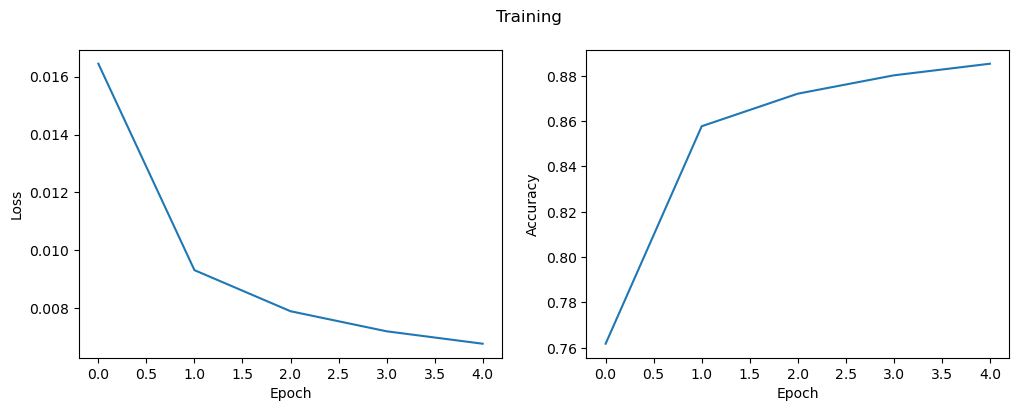

In [134]:
fit(model, x_train, y_train, criterion, LEARNING_RATE, NUM_EPOCHS, BATCH_SIZE)

# nn.Linear

Instead of manually defining and initializing the affine layer, we can instead use the PyTorch class `nn.Linear`. PyTorch provides a wide range of predefined layers to simplify our code (and make it faster). On GitHub you will find layers for pretty much anything you might want to do.

In [136]:
@beartype
class LogisticRegression(nn.Module):
    """Logistic regression model.

    The model consists of a single linear layer that maps from the number of features to the number of classes.
    """

    def __init__(self, num_features: int, num_classes: int) -> None:
        """Constructor method for LogisticRegression.

        Args:
            num_features: the number of features
            num_classes: the number of classes
        """
        super().__init__()
        # define the linear layer
        self.lin = nn.Linear(num_features, num_classes, bias=True)

        # initialize the weights
        self.init_weights()

    def init_weights(self):
        """Initialize the weights.

        The weight is initialized using Xavier uniform initialization and the bias is initialized to zero.
        """
        if isinstance(self.lin, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(self.lin.weight)
            if self.lin.bias is not None:
                nn.init.zeros_(self.lin.bias)

    def forward(self, x: Float[Tensor, "batch channels width height"]) -> Float[Tensor, "batch classes"]:
        """Forward pass.

        Args:
            x: the input tensor

        Returns:
            the logits
        """
        return self.lin(x.flatten(start_dim=1))

Epoch 1/5 | Loss: 0.0169 | Accuracy: 0.7470
Epoch 2/5 | Loss: 0.0093 | Accuracy: 0.8580
Epoch 3/5 | Loss: 0.0079 | Accuracy: 0.8732
Epoch 4/5 | Loss: 0.0072 | Accuracy: 0.8804
Epoch 5/5 | Loss: 0.0068 | Accuracy: 0.8856


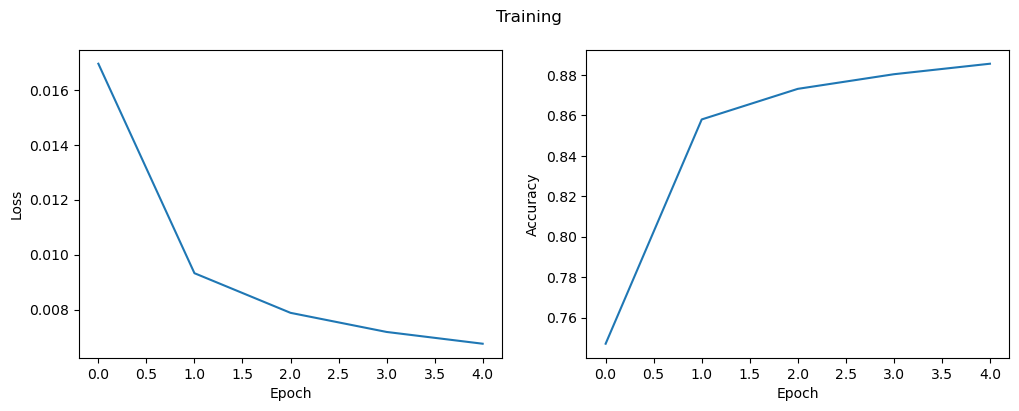

In [138]:
set_seed(SEED)
model = LogisticRegression(NUM_FEATURES, NUM_CLASSES)
criterion = F.cross_entropy
fit(model, x_train, y_train, criterion, LEARNING_RATE, NUM_EPOCHS, BATCH_SIZE)

# torch.optim

`torch.optim` provides various optimization algorithms. Here we will continue to use simple `SGD`, but you could just as easily switch to Adam or AMSgrad. Optimizers provide `.step()` and `.zero_grad()` methods, which allows us to make the last block in our `fit` function more concise.

In [140]:
set_seed(SEED)
model = LogisticRegression(NUM_FEATURES, NUM_CLASSES)
criterion = F.cross_entropy

# define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [142]:
@beartype
def fit(
    model: torch.nn.Module,
    x_train: Tensor,
    y_train: Tensor,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    batch_size: int,
) -> None:
    """Train the model.

    Args:
        model: the model (an instance of torch.nn.Module)
        x_train: the training features tensor
        y_train: the training labels tensor
        criterion: a callable that returns the loss given the logits and the labels
        optimizer: the optimizer (an instance of torch.optim.Optimizer)
        num_epochs: the number of epochs
        batch_size: the batch size
    """
    num_train = x_train.shape[0]
    num_batches = int(np.ceil(num_train / batch_size))

    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_acc = 0.0

        for i in range(num_batches):
            start_i = i * batch_size
            end_i = min(start_i + batch_size, num_train)
            x_batch = x_train[start_i:end_i]
            y_batch = y_train[start_i:end_i]

            pred = model(x_batch)
            loss = criterion(pred, y_batch)

            # Zero out the gradients
            optimizer.zero_grad()

            # Compute gradients
            loss.backward()

            # Optimization step
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += torch.sum(pred.argmax(-1) == y_batch).item()

        epoch_loss /= num_train
        epoch_acc /= num_train

        print_epoch_summary(epoch, num_epochs, epoch_loss, epoch_acc)

        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

    plot_curves(loss_history, acc_history, "Training")

Epoch 1/5 | Loss: 0.0169 | Accuracy: 0.7470
Epoch 2/5 | Loss: 0.0093 | Accuracy: 0.8580
Epoch 3/5 | Loss: 0.0079 | Accuracy: 0.8732
Epoch 4/5 | Loss: 0.0072 | Accuracy: 0.8804
Epoch 5/5 | Loss: 0.0068 | Accuracy: 0.8856


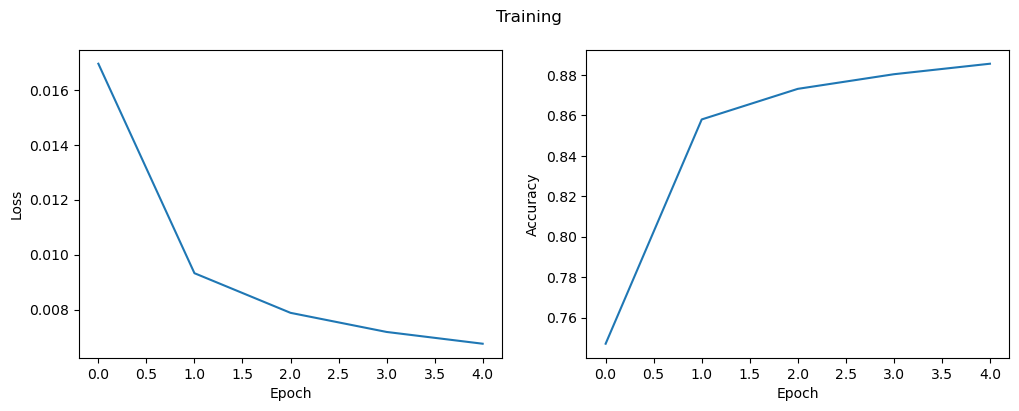

In [144]:
fit(model, x_train, y_train, criterion, optimizer, NUM_EPOCHS, BATCH_SIZE)

# Dataset
As already mentioned, `torch.utils.data.Dataset` is a very useful class that allows you to easily load and process data in PyTorch.

A Dataset only needs to provide a `__len__` (which is called by Python's `len` function) and a `__getitem__` function for indexing the dataset.

`TensorDataset` provides an easy way of converting tensors to datasets. This will make our data loading more concise, since we can handle both `x_train` and `y_train` simultaneously.

In [146]:
from torch.utils.data import TensorDataset

# create Tensor datasets
train_dataset = TensorDataset(x_train, y_train)

In [148]:
@beartype
def fit(
    model: torch.nn.Module,
    train_dataset: torch.utils.data.Dataset,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    batch_size: int,
) -> None:
    """Train the model.

    Args:
        model: the model (an instance of torch.nn.Module)
        train_dataset: the training dataset (an instance of torch.utils.data.Dataset)
        criterion: a callable that returns the loss given the logits and the labels
        optimizer: the optimizer (an instance of torch.optim.Optimizer)
        num_epochs: the number of epochs
        batch_size: the batch size
    """
    num_train = x_train.shape[0]
    num_batches = int(np.ceil(num_train / batch_size))

    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_acc = 0.0

        for i in range(num_batches):
            start_i = i * batch_size
            end_i = min(start_i + batch_size, num_train)
            x_batch, y_batch = train_dataset[start_i:end_i]

            pred = model(x_batch)
            loss = criterion(pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += torch.sum(pred.argmax(-1) == y_batch).item()

        epoch_loss /= num_train
        epoch_acc /= num_train

        print_epoch_summary(epoch, num_epochs, epoch_loss, epoch_acc)

        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

    plot_curves(loss_history, acc_history, "Training")

Epoch 1/5 | Loss: 0.0169 | Accuracy: 0.7470
Epoch 2/5 | Loss: 0.0093 | Accuracy: 0.8580
Epoch 3/5 | Loss: 0.0079 | Accuracy: 0.8732
Epoch 4/5 | Loss: 0.0072 | Accuracy: 0.8804
Epoch 5/5 | Loss: 0.0068 | Accuracy: 0.8856


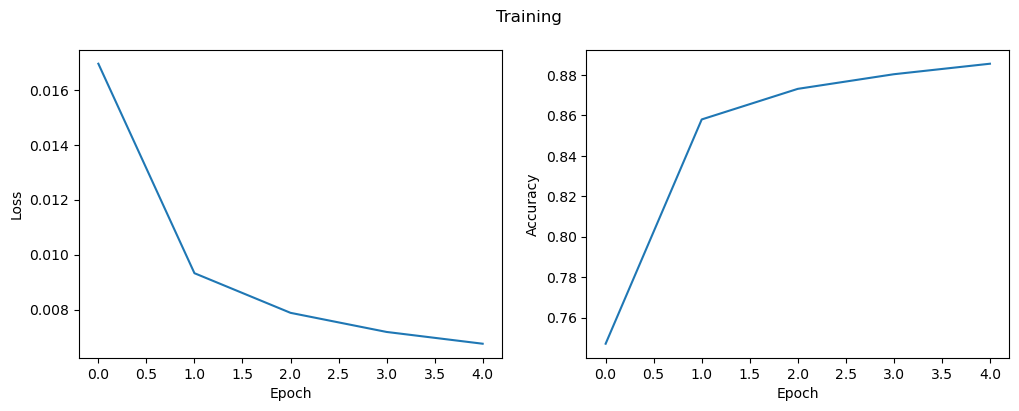

In [150]:
set_seed(SEED)
model = LogisticRegression(NUM_FEATURES, NUM_CLASSES)
criterion = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

fit(model, train_dataset, criterion, optimizer, NUM_EPOCHS, BATCH_SIZE)

At the beginning of this tutorial we downloaded the MNIST dataset using `torchvision`. This is a subclass of `torch.utils.data.Dataset`. Instead of working with the raw data, we can instead use this class directly. This will make our code more concise and readable.

Let's download the data again for demonstration purposes.

In [152]:
mnist_train = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_test = torchvision.datasets.MNIST("./data", train=False, download=True)

Since `MNIST` is a subclass of `torch.utils.data.Dataset` it already provides `__len__` and `__getitem__` functions.

In [155]:
print(len(mnist_train))
print(mnist_train[0])

60000
(<PIL.Image.Image image mode=L size=28x28 at 0x11A909AEFF0>, 5)


## Transforms

The `__getitem__` method is the most important one. It is used to load and process the data. In the case of the MNIST dataset, the `__getitem__` method returns a tuple containing the image and the label of the image at the given index.

As a `PIL` image is returned, we have to:
1. convert it to a `Tensor` (we will introduce `Tensor`s later);
2. normalize the image.

Torchvision provides a `transforms` module that contains a lot of useful functions for data preprocessing and augmentation. In this case we will use the `ToTensor` and `Normalize` functions.

If we want to use multiple transforms, we can use the `Compose` function to combine them into a single transform.

Let's download again the MNIST dataset, but this time we will use the `transforms` module to convert the images to `Tensor`s and normalize them.

In [157]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize((0.1307,), (0.3081,))
])
mnist_train = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=transform
)

mnist_test = torchvision.datasets.MNIST(
    "./data", train=False, download=True, transform=transform
)

mnist_train, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  ToDtype(scale=True)
                  Normalize(mean=[0.1307], std=[0.3081], inplace=False)
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  ToDtype(scale=True)
                  Normalize(mean=[0.1307], std=[0.3081], inplace=False)
            ))

In [54]:
image, label = mnist_train[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

Instead of splitting the dataset into a training and validation set manually, we can use `random_split` to do this for us.

In [159]:
mnist_train_split, mnist_val_split = torch.utils.data.random_split(
    mnist_train, [50000, 10000]
)
mnist_train_split, mnist_val_split

(<torch.utils.data.dataset.Subset at 0x11a8c9fd880>,
 <torch.utils.data.dataset.Subset at 0x11a908f61b0>)

`mnist_train_split` and `mnist_val_split` are both `Subset` objects, which are subclasses of `torch.utils.data.Dataset`. They are used to select a subset of the data, and they still implement the `__getitem__` and `__len__` methods.

In [162]:
image, label = mnist_train_split[0]
len(mnist_train_split), image.shape, label

(50000, torch.Size([1, 28, 28]), 9)

Let's have a final check to sizes, dtypes, etc. of the data.

In [165]:
print(
    f"Train | Num. of samples: {len(mnist_train_split)}, X shape: {mnist_train_split[0][0].shape}"
)
print(
    f"Val   | Num. of samples: {len(mnist_val_split)}, X shape: {mnist_val_split[0][0].shape}"
)
print(f"Test  | Num. of samples: {len(mnist_test)}, X shape: {mnist_test[0][0].shape}")

Train | Num. of samples: 50000, X shape: torch.Size([1, 28, 28])
Val   | Num. of samples: 10000, X shape: torch.Size([1, 28, 28])
Test  | Num. of samples: 10000, X shape: torch.Size([1, 28, 28])


# DataLoader

A `DataLoader` automatically generates mini-batches for your training loop. It can run multiple workers in parallel and provides useful functionality such as data shuffling. You can create a `DataLoader` for any `Dataset`.

In [184]:
from torch.utils.data import DataLoader

# create DataLoader
train_generator = torch.Generator().manual_seed(SEED)
train_dataloader = DataLoader(
    dataset=mnist_test, batch_size=BATCH_SIZE, generator=train_generator
)

Let's see how the `DataLoader` works.

In [186]:
# iterate over the DataLoader
x_batch, y_batch = next(iter(train_dataloader))
# for x_batch, y_batch in train dataloader

Using the DataLoader makes our training loop a lot cleaner:

In [172]:
@beartype
def fit(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
) -> None:
    """Train the model.

    Args:
        model: the model (an instance of torch.nn.Module)
        train_dataloader: the training dataloader (an instance of torch.utils.data.DataLoader)
        criterion: a callable that returns the loss given the logits and the labels
        optimizer: the optimizer (an instance of torch.optim.Optimizer)
        num_epochs: the number of epochs
    """
    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        n = 0
        epoch_loss = 0.0
        epoch_acc = 0.0

        for x_batch, y_batch in train_dataloader:
            pred = model(x_batch)
            loss = criterion(pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            n += len(x_batch)
            epoch_loss += loss.item()
            epoch_acc += torch.sum(pred.argmax(dim=-1) == y_batch).item()

        epoch_loss /= n
        epoch_acc /= n

        print_epoch_summary(epoch, num_epochs, epoch_loss, epoch_acc)

        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

    plot_curves(loss_history, acc_history, "Training")

Epoch 1/5 | Loss: 0.0145 | Accuracy: 0.7187
Epoch 2/5 | Loss: 0.0072 | Accuracy: 0.8677
Epoch 3/5 | Loss: 0.0061 | Accuracy: 0.8866
Epoch 4/5 | Loss: 0.0056 | Accuracy: 0.8968
Epoch 5/5 | Loss: 0.0053 | Accuracy: 0.9028


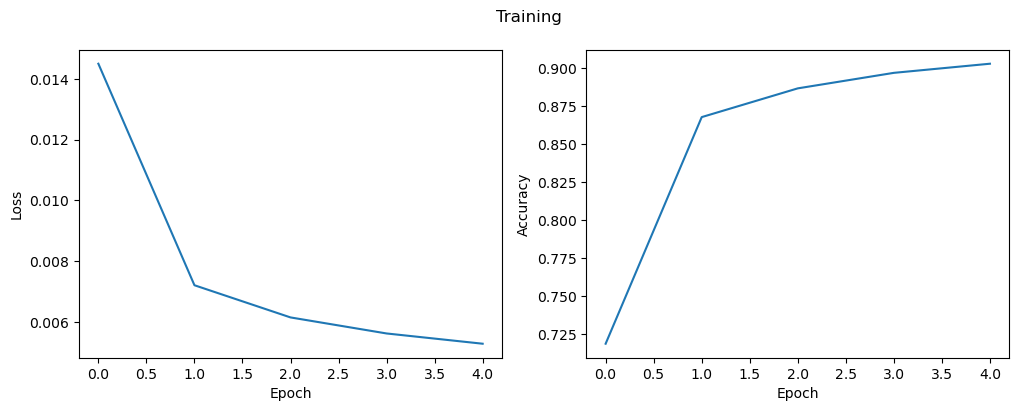

In [174]:
set_seed(SEED)
model = LogisticRegression(NUM_FEATURES, NUM_CLASSES)
criterion = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

fit(model, train_dataloader, criterion, optimizer, NUM_EPOCHS)

# Validation

Now that we have a training loop we can go ahead and do some real work. To avoid overfitting, enable early stopping and have some information for model development we always need a validation set.

Since the validation set does not need backpropagation we can use 2x larger batches for it. Furthermore, we should shuffle our training data to avoid correlation between batches. This is not necessary (and would waste computation time) for the validation set.

In [192]:
dataloaders = {}
train_generator = torch.Generator().manual_seed(SEED)
dataloaders["train"] = DataLoader(
    mnist_train_split, batch_size=BATCH_SIZE, shuffle=True, generator=train_generator
)
dataloaders["val"] = DataLoader(mnist_val_split, batch_size=2 * BATCH_SIZE, shuffle=False)

Note that you need to call `model.train()` before training and `model.eval()` before evaluation (inference), since some layers like dropout and batch normalization work differently in each mode.

In [194]:
@beartype
def fit(
    model: torch.nn.Module,
    dataloaders: dict[str, torch.utils.data.DataLoader],
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
) -> None:
    """Train the model.

    Args:
        model: the model (an instance of torch.nn.Module)
        dataloaders: the dictionary of dataloaders (an instance of torch.utils.data.DataLoader)
        criterion: a callable that returns the loss given the logits and the labels
        optimizer: the optimizer (an instance of torch.optim.Optimizer)
        num_epochs: the number of epochs
    """
    loss_history = {"train": [], "val": []}
    acc_history = {"train": [], "val": []}

    for epoch in range(num_epochs):
        epoch_loss = {"train": 0.0, "val": 0.0}
        epoch_acc = {"train": 0.0, "val": 0.0}

        # Training
        model.train()
        for x_batch, y_batch in dataloaders["train"]:
            pred = model(x_batch)
            loss = criterion(pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss["train"] += loss.item()
            epoch_acc["train"] += torch.sum(pred.argmax(-1) == y_batch).item()

        epoch_loss["train"] /= len(dataloaders["train"].dataset)
        epoch_acc["train"] /= len(dataloaders["train"].dataset)

        # Validation
        model.eval()
        for x_batch, y_batch in dataloaders["val"]:
            with torch.inference_mode():
                pred = model(x_batch)
                loss = criterion(pred, y_batch)

            epoch_loss["val"] += loss.item()
            epoch_acc["val"] += torch.sum(pred.argmax(-1) == y_batch).item()

        epoch_loss["val"] /= len(dataloaders["val"].dataset)
        epoch_acc["val"] /= len(dataloaders["val"].dataset)

        print_epoch_summary(epoch, num_epochs, epoch_loss, epoch_acc)

        loss_history["train"].append(epoch_loss["train"])
        loss_history["val"].append(epoch_loss["val"])
        acc_history["train"].append(epoch_acc["train"])
        acc_history["val"].append(epoch_acc["val"])

    training_history = {"loss": loss_history["train"], "acc": acc_history["train"]}
    validation_history = {"loss": loss_history["val"], "acc": acc_history["val"]}
    plot_curves(training_history, validation_history)


@beartype
def print_epoch_summary(
    epoch: int, num_epochs: int, loss: dict[str, float], acc: dict[str, float]
) -> None:
    """Print the epoch summary.

    The summary includes the epoch number, the number of epochs, the loss, and the accuracy.

    Args:
        epoch: the epoch number
        num_epochs: the number of epochs
        loss: the loss
        acc: the accuracy
    """
    print(
        f"Epoch {epoch+1:>{len(str(num_epochs))}}/{num_epochs} | "
        f"Train - loss: {loss['train']:.4f}, acc: {acc['train']:.4f} | "
        f"Val - loss: {loss['val']:.4f}, acc: {acc['val']:.4f}"
    )


@beartype
def plot_curves(
    training_history: dict[str, list], validation_history: dict[str, list]
) -> None:
    """Plot the loss and accuracy curves.

    It plots the loss curve on the left and the accuracy curve on the right via matplotlib.

    Args:
        training_history: the training history
        validation_history: the validation history
    """
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(training_history["loss"], label="Training")
    ax1.plot(validation_history["loss"], label="Validation")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax2.plot(training_history["acc"], label="Training")
    ax2.plot(validation_history["acc"], label="Validation")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    plt.show()

Epoch 1/5 | Train - loss: 0.0084, acc: 0.8422 | Val - loss: 0.0029, acc: 0.8978
Epoch 2/5 | Train - loss: 0.0055, acc: 0.8969 | Val - loss: 0.0026, acc: 0.9064
Epoch 3/5 | Train - loss: 0.0051, acc: 0.9049 | Val - loss: 0.0024, acc: 0.9137
Epoch 4/5 | Train - loss: 0.0049, acc: 0.9099 | Val - loss: 0.0024, acc: 0.9170
Epoch 5/5 | Train - loss: 0.0048, acc: 0.9133 | Val - loss: 0.0023, acc: 0.9190


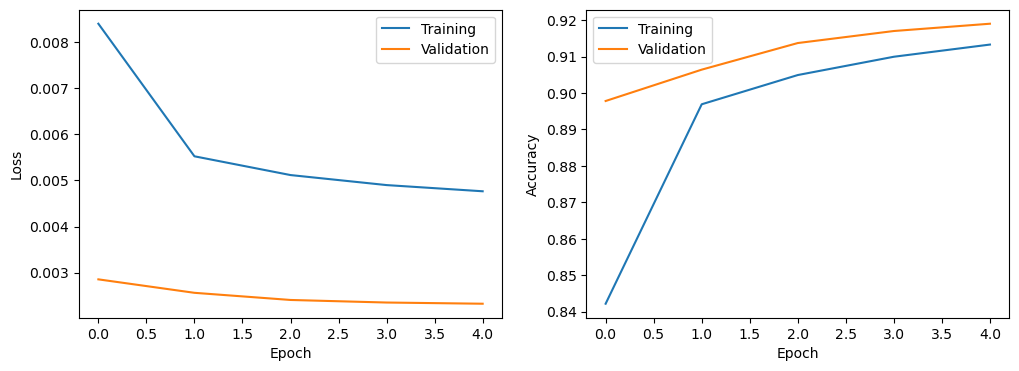

In [182]:
set_seed(SEED)
model = LogisticRegression(NUM_FEATURES, NUM_CLASSES)
criterion = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

fit(model, dataloaders, criterion, optimizer, NUM_EPOCHS)

What happens if we let the model train for more epochs?

With data shuffling:
![](img/validation_curves_shuffle.png)

Without data shuffling:
![](img/validation_curves_no_shuffle.png)

Before we continue, let's make our training loop a bit more concise.

In [196]:
@beartype
def run_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: Callable,
    optimizer: torch.optim.Optimizer | None = None,
    train: bool = False,
) -> tuple[float, float]:
    """Run one epoch.

    It runs one epoch of training, validation, or test, and returns the loss and accuracy. If training is True, it also updates the parameters.

    Args:
        model: the model (an instance of torch.nn.Module)
        dataloader: the dataloader (an instance of torch.utils.data.DataLoader)
        criterion: a callable that returns the loss given the logits and the labels
        optimizer: the optimizer (an instance of torch.optim.Optimizer). Defaults to None.
        train: whether to train the model. Defaults to False.

    Returns:
        the loss and accuracy
    """
    epoch_loss = 0.0
    epoch_acc = 0.0

    if train:
        model.train()
    else:
        model.eval()

    for x_batch, y_batch in dataloader:
        with torch.set_grad_enabled(train):
            pred = model(x_batch)
            loss = criterion(pred, y_batch)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += (pred.argmax(-1) == y_batch).sum().item()

    epoch_loss /= len(dataloader.dataset)
    epoch_acc /= len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [198]:
@beartype
def fit(
    model: torch.nn.Module,
    dataloaders: dict[str, torch.utils.data.DataLoader],
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
) -> None:
    """Train the model.

    Args:
        model: the model (an instance of torch.nn.Module)
        dataloaders: the dictionary of dataloaders (an instance of torch.utils.data.DataLoader)
        criterion: a callable that returns the loss given the logits and the labels
        optimizer: the optimizer (an instance of torch.optim.Optimizer)
        num_epochs: the number of epochs
    """
    loss_history = {"train": [], "val": []}
    acc_history = {"train": [], "val": []}

    for epoch in range(num_epochs):
        # Training
        train_loss, train_acc = run_epoch(
            model, dataloaders["train"], criterion, optimizer, train=True
        )

        # Validation
        val_loss, val_acc = run_epoch(model, dataloaders["val"], criterion, train=False)

        loss = {"train": train_loss, "val": val_loss}
        acc = {"train": train_acc, "val": val_acc}
        print_epoch_summary(epoch, num_epochs, loss, acc)

        loss_history["train"].append(train_loss)
        loss_history["val"].append(val_loss)
        acc_history["train"].append(train_acc)
        acc_history["val"].append(val_acc)

    training_history = {"loss": loss_history["train"], "acc": acc_history["train"]}
    validation_history = {"loss": loss_history["val"], "acc": acc_history["val"]}
    plot_curves(training_history, validation_history)

Epoch 1/5 | Train - loss: 0.0084, acc: 0.8422 | Val - loss: 0.0029, acc: 0.8978
Epoch 2/5 | Train - loss: 0.0055, acc: 0.8969 | Val - loss: 0.0026, acc: 0.9064
Epoch 3/5 | Train - loss: 0.0051, acc: 0.9049 | Val - loss: 0.0024, acc: 0.9137
Epoch 4/5 | Train - loss: 0.0049, acc: 0.9099 | Val - loss: 0.0024, acc: 0.9170
Epoch 5/5 | Train - loss: 0.0048, acc: 0.9133 | Val - loss: 0.0023, acc: 0.9190


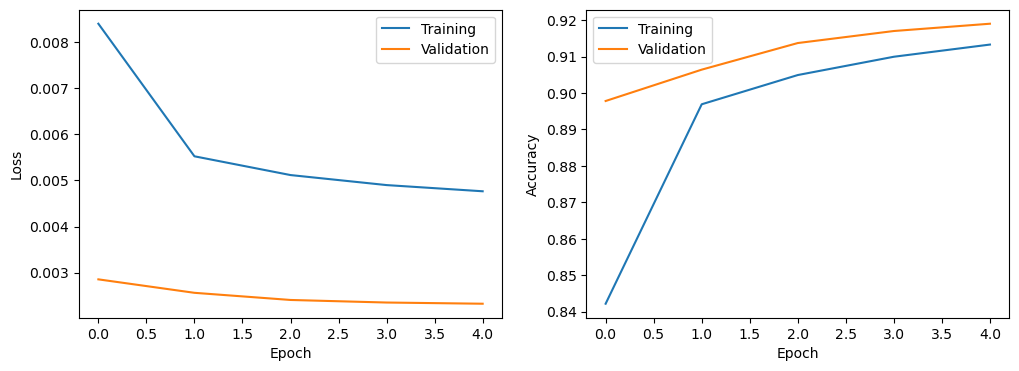

In [200]:
set_seed(SEED)
model = LogisticRegression(NUM_FEATURES, NUM_CLASSES)
criterion = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

fit(model, dataloaders, criterion, optimizer, NUM_EPOCHS)

# Testing

Now that we have a trained model we can use it to make predictions on the test set. We can then use these predictions to calculate the accuracy on the test set.

In [202]:
test_dataloader = DataLoader(dataset=mnist_test, batch_size=2 * BATCH_SIZE, shuffle=False)

In [204]:
test_loss, test_acc = run_epoch(model, test_dataloader, criterion, train=False)
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

Test - loss: 0.0023, acc: 0.9151


# CNN
Using simple logistic regression (or an MLP) for images basically ignores the data's underlying structure. We can do much better than this by switching to a CNN. Since our training loop does not assume anything about the model we can train a CNN without any changes.

Our CNN will consist of 3 convolutional layers, each using PyTorch's predefined `Conv2d` layer. At the End, we perform average pooling. Since `Conv2d` assumes a shape of `[batch_size, num_channels, height, width]` we need to reshape our input inside the model via `.view(_)`.

In [206]:
@beartype
class CNN(nn.Module):
    """Convolutional neural network model."""

    def __init__(self, num_channels: int, num_classes: int) -> None:
        """Constructor method for CNN.

        Args:
            num_channels: the number of channels
            num_classes: the number of classes
        """
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=num_channels,
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_channels,
            out_channels=num_channels,
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.conv3 = nn.Conv2d(
            in_channels=num_channels,
            out_channels=num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
        )

        self.init_weights()

    def init_weights(self) -> None:
        """Initialize the parameters.

        The weight is initialized using Xavier uniform initialization and the bias is initialized to zero.
        """
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.xavier_normal_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)

    def forward(self, x: Float[Tensor, "batch channels height width"]) -> Float[Tensor, "batch classes"]:
        """Forward pass.

        Args:
            x: the input tensor

        Returns:
            the logits
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x, 4)
        return x[:, :, 0, 0]

We will now furthermore use momentum in our optimizer to speed up training.

Epoch 1/5 | Train - loss: 0.0099, acc: 0.7956 | Val - loss: 0.0025, acc: 0.8973
Epoch 2/5 | Train - loss: 0.0040, acc: 0.9252 | Val - loss: 0.0015, acc: 0.9434
Epoch 3/5 | Train - loss: 0.0031, acc: 0.9407 | Val - loss: 0.0012, acc: 0.9526
Epoch 4/5 | Train - loss: 0.0027, acc: 0.9479 | Val - loss: 0.0013, acc: 0.9455
Epoch 5/5 | Train - loss: 0.0026, acc: 0.9507 | Val - loss: 0.0012, acc: 0.9528


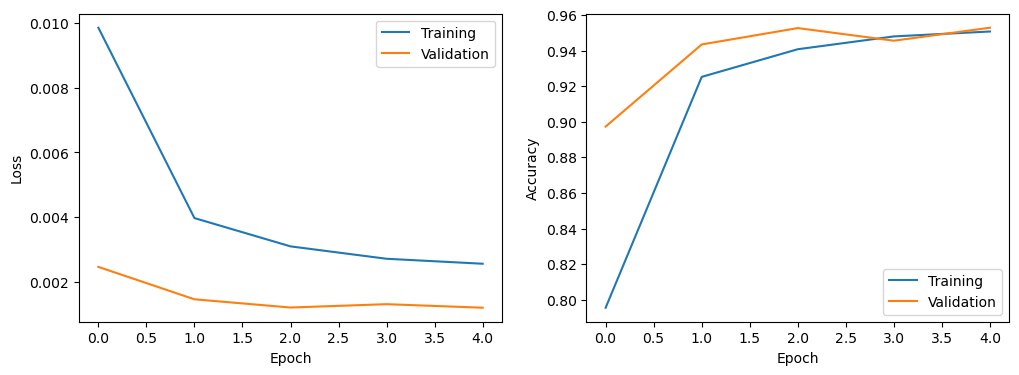

In [208]:
NUM_CHANNELS = 16
LEARNING_RATE = 0.1
MOMENTUM = 0.9

set_seed(SEED)
model = CNN(num_channels=NUM_CHANNELS, num_classes=NUM_CLASSES)
criterion = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

fit(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS)

In [209]:
run_epoch(model, test_dataloader, criterion, train=False)

(0.0012033797067590058, 0.9544)

# GPUs

PyTorch can run significantly faster on a GPU than on a CPU, so you should always try to leverage that hardware. To do so, you need to move both your model and your data to the device.

So let's first check if you have a GPU and choose the appropriate device.

**Note**: If you are using Google Colab, you can go to `Runtime -> Change runtime type` and select `GPU` as hardware accelerator.

In [212]:
# check if GPU is available
print(torch.cuda.is_available())

# set the device to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


Now, we can move our model to the device.

In [214]:
# check model device
print(model.conv1.weight.device)
model.to(device)
print(model.conv1.weight.device)

cpu
cuda:0


Then, we redefine the DataLoader to:
1. **pin the memory**: this is a trick that will accelerate moving data between CPU and GPU (have a look at [the documentation](https://pytorch.org/docs/stable/data.html#memory-pinning) and [this explanation](https://stackoverflow.com/a/55564072) for more information);
2. **use more workers**: the `num_workers` argument specifies how many subprocesses to use for data loading. Setting it to a higher number will speed up data loading (have a look at [the documentation](https://pytorch.org/docs/stable/data.html#multi-process-data-loading) for more information).

**Note**: Jupyter notebooks do not play well with multiprocessing, so you might want to set `num_workers=0` if you are using a Jupyter notebook.

In [216]:
NUM_WORKERS = 0


def instantiate_dataloaders(
    train_dataset: torch.utils.data.Dataset,
    val_dataset: torch.utils.data.Dataset,
    test_dataset: torch.utils.data.Dataset,
    batch_size: int,
    num_workers: int,
    seed: int,
) -> dict[str, torch.utils.data.DataLoader]:
    """Instantiate dataloaders.

    Args:
        train_dataset: the training dataset
        val_dataset: the validation dataset
        test_dataset: the test dataset
        batch_size: the batch size
        num_workers: the number of workers
        seed: the seed

    Returns:
        the dictionary of dataloaders
    """
    dataloaders = {}
    dataloaders["train"] = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=num_workers,
        generator=torch.Generator().manual_seed(seed),
    )
    dataloaders["val"] = DataLoader(
        val_dataset,
        batch_size=2 * batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=num_workers,
    )
    dataloaders["test"] = DataLoader(
        test_dataset,
        batch_size=2 * batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=num_workers,
    )
    return dataloaders

#### How to set the number of workers?

Well, it depends on your hardware. The first thing you should do is to check how many cores your CPU has.

In [219]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)

Number of CPU cores: 32


Secondly, you should do some quick benchmarking to see how the number of workers affects the data loading time. You can do this by setting `num_workers` to different values and measuring the time it takes to load the data. You can use the `%%timeit` magic command to do this.

In [222]:
%%timeit -n 1 -r 3
for x_batch, y_batch in dataloaders["train"]:
    pass

4.93 s ± 12.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Finally, we need to slightly change our training loop to send each batch to the device first.

In [224]:
@beartype
def run_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: Callable,
    device: torch.device = torch.device("cpu"),
    optimizer: torch.optim.Optimizer | None = None,
    train: bool = False,
) -> tuple[float, float]:
    """Run one epoch.

    It runs one epoch of training, validation, or test, and returns the loss and accuracy. If training is True, it also updates the parameters.

    Args:
        model: the model (an instance of torch.nn.Module)
        dataloader: the dataloader (an instance of torch.utils.data.DataLoader)
        criterion: a callable that returns the loss given the logits and the labels
        device: the device (cpu or gpu). Defaults to torch.device("cpu").
        optimizer: the optimizer (an instance of torch.optim.Optimizer). Defaults to None.
        train: whether to train the model. Defaults to False.

    Returns:
        the loss and accuracy
    """
    epoch_loss = 0.0
    epoch_acc = 0.0

    # Move model to the device
    model = model.to(device)

    if train:
        model.train()
    else:
        model.eval()

    for x_batch, y_batch in dataloader:
        # Move data to the device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.set_grad_enabled(train):
            pred = model(x_batch)
            loss = criterion(pred, y_batch)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += (pred.argmax(-1) == y_batch).sum().item()

    epoch_loss /= len(dataloader.dataset)
    epoch_acc /= len(dataloader.dataset)

    return epoch_loss, epoch_acc


@beartype
def fit(
    model: torch.nn.Module,
    dataloaders: dict[str, torch.utils.data.DataLoader],
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    device: torch.device = torch.device("cpu"),
) -> None:
    """Train the model.

    Args:
        model: the model (an instance of torch.nn.Module)
        dataloaders: the dictionary of dataloaders (an instance of torch.utils.data.DataLoader)
        criterion: a callable that returns the loss given the logits and the labels
        optimizer: the optimizer (an instance of torch.optim.Optimizer)
        num_epochs: the number of epochs
        device: the device (cpu or gpu). Defaults to torch.device("cpu").
    """
    loss_history = {"train": [], "val": []}
    acc_history = {"train": [], "val": []}

    for epoch in range(num_epochs):
        # Training
        train_loss, train_acc = run_epoch(
            model, dataloaders["train"], criterion, device, optimizer, train=True
        )

        # Validation
        val_loss, val_acc = run_epoch(
            model, dataloaders["val"], criterion, device, train=False
        )

        loss = {"train": train_loss, "val": val_loss}
        acc = {"train": train_acc, "val": val_acc}
        print_epoch_summary(epoch, num_epochs, loss, acc)

        loss_history["train"].append(train_loss)
        loss_history["val"].append(val_loss)
        acc_history["train"].append(train_acc)
        acc_history["val"].append(val_acc)

    training_history = {"loss": loss_history["train"], "acc": acc_history["train"]}
    validation_history = {"loss": loss_history["val"], "acc": acc_history["val"]}
    plot_curves(training_history, validation_history)

And now we can run our CNN on the GPU!

Epoch 1/5 | Train - loss: 0.0102, acc: 0.7912 | Val - loss: 0.0024, acc: 0.9030
Epoch 2/5 | Train - loss: 0.0040, acc: 0.9217 | Val - loss: 0.0018, acc: 0.9250
Epoch 3/5 | Train - loss: 0.0032, acc: 0.9388 | Val - loss: 0.0013, acc: 0.9483
Epoch 4/5 | Train - loss: 0.0027, acc: 0.9469 | Val - loss: 0.0012, acc: 0.9557
Epoch 5/5 | Train - loss: 0.0024, acc: 0.9523 | Val - loss: 0.0010, acc: 0.9588


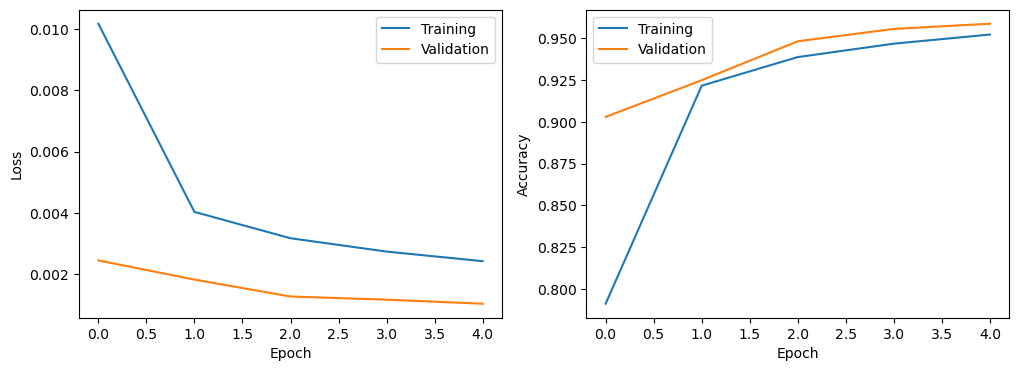

In [226]:
set_seed(SEED)
model = CNN(num_channels=NUM_CHANNELS, num_classes=NUM_CLASSES)
criterion = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
dataloaders = instantiate_dataloaders(
    mnist_train_split, mnist_val_split, mnist_test, BATCH_SIZE, NUM_WORKERS, SEED
)

fit(model, dataloaders, criterion, optimizer, NUM_EPOCHS, device)

In [227]:
test_loss, test_acc = run_epoch(model, dataloaders["test"], criterion, train=False)
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

Test - loss: 0.0010, acc: 0.9597


# nn.Sequential

PyTorch provides a class `nn.Sequential` for simplifying the definition of modules that only consist of a stack of layers. Since these are exactly the models we have been using so far we will now switch to this interface.

We can now define our CNN in a more concise manner. Note that we now use `nn.AdaptiveAvgPool2d`, which allows us to specify the size of the output tensor instead of the input tensor.

In [232]:
set_seed(SEED)
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1),
)

When we don't have control on the model class (i.e., we cannot define a member function such as `init_weights` within the class itself), we can define a function and apply it to the model with `.apply(_)`.

In [235]:
@beartype
def initialize_weights(m: nn.Module) -> None:
    """Initialize the weights.

    The weight is initialized using Xavier uniform initialization and the bias is initialized to zero.

    Args:
        m: the module (an instance of torch.nn.Module)
    """
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


model.apply(initialize_weights)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): AdaptiveAvgPool2d(output_size=1)
  (7): Flatten(start_dim=1, end_dim=-1)
)

Epoch 1/5 | Train - loss: 0.0102, acc: 0.7910 | Val - loss: 0.0023, acc: 0.9166
Epoch 2/5 | Train - loss: 0.0039, acc: 0.9264 | Val - loss: 0.0018, acc: 0.9286
Epoch 3/5 | Train - loss: 0.0031, acc: 0.9416 | Val - loss: 0.0017, acc: 0.9353
Epoch 4/5 | Train - loss: 0.0027, acc: 0.9483 | Val - loss: 0.0013, acc: 0.9494
Epoch 5/5 | Train - loss: 0.0024, acc: 0.9519 | Val - loss: 0.0011, acc: 0.9606


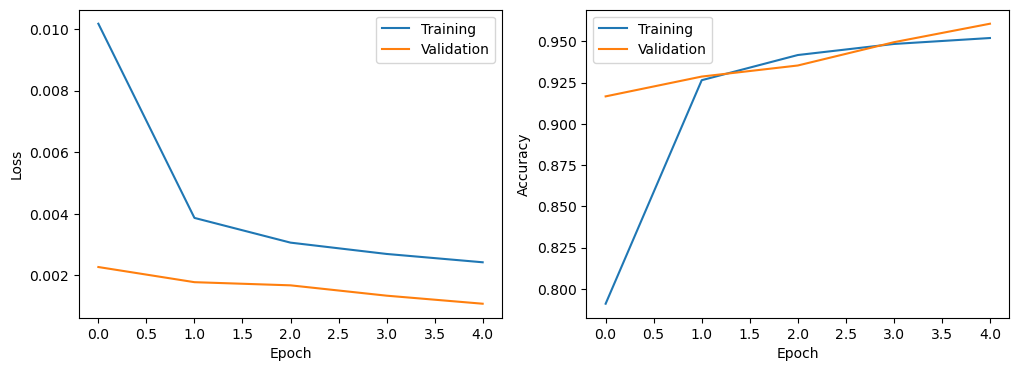

In [237]:
criterion = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
dataloaders = instantiate_dataloaders(
    mnist_train_split, mnist_val_split, mnist_test, BATCH_SIZE, NUM_WORKERS, SEED
)

fit(model, dataloaders, criterion, optimizer, NUM_EPOCHS, device=device)

In [99]:
test_loss, test_acc = run_epoch(model, dataloaders["test"], criterion, train=False)
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

Test - loss: 0.0016, acc: 0.9412


# nn.ModuleList

A similar approach to `nn.Sequential` is `nn.ModuleList`, which allows you to define a list of layers. This is useful when you want to define a model that has a variable number of layers.

In [239]:
@beartype
class CNN(nn.Module):
    """Convolutional neural network model."""

    def __init__(self, num_layers: int, num_channels: int, num_classes: int) -> None:
        """Constructor method for CNN.

        Args:
            num_layers: the number of layers
            num_channels: the number of channels
            num_classes: the number of classes
        """
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            in_channels = 1 if i == 0 else num_channels
            out_channels = num_channels if i < num_layers - 1 else num_classes
            self.layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                )
            )
            self.layers.append(nn.ReLU())
        self.layers.append(nn.AdaptiveAvgPool2d(1))

        self.init_weights()

    def init_weights(self) -> None:
        """Initialize the parameters.

        The weight is initialized using Xavier uniform initialization and the bias is initialized to zero.
        """
        for layer in self.layers:
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: the input tensor

        Returns:
            the logits
        """
        x = x.view(-1, 1, 28, 28)
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        return x

Epoch 1/5 | Train - loss: 0.0101, acc: 0.7930 | Val - loss: 0.0026, acc: 0.8975
Epoch 2/5 | Train - loss: 0.0041, acc: 0.9226 | Val - loss: 0.0018, acc: 0.9269
Epoch 3/5 | Train - loss: 0.0033, acc: 0.9358 | Val - loss: 0.0015, acc: 0.9384
Epoch 4/5 | Train - loss: 0.0028, acc: 0.9453 | Val - loss: 0.0013, acc: 0.9480
Epoch 5/5 | Train - loss: 0.0025, acc: 0.9510 | Val - loss: 0.0012, acc: 0.9542


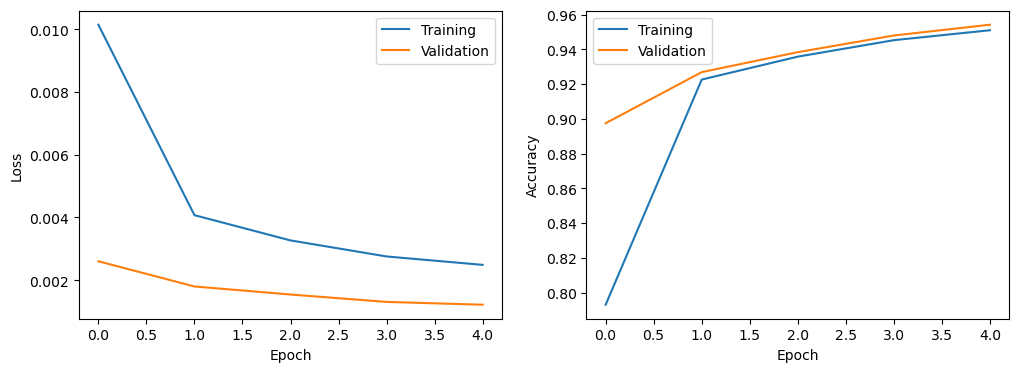

In [241]:
set_seed(SEED)
NUM_LAYERS = 3
model = CNN(num_layers=NUM_LAYERS, num_channels=NUM_CHANNELS, num_classes=NUM_CLASSES)
criterion = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
dataloaders = instantiate_dataloaders(
    mnist_train_split, mnist_val_split, mnist_test, BATCH_SIZE, NUM_WORKERS, SEED
)

fit(model, dataloaders, criterion, optimizer, NUM_EPOCHS, device=device)

In [102]:
test_loss, test_acc = run_epoch(model, dataloaders["test"], criterion, train=False)
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

Test - loss: 0.0016, acc: 0.9379


# Early stopping and checkpointing

Early stopping is a very useful technique for avoiding overfitting. It works by monitoring the validation loss and stopping training when it starts to increase. This is a very simple and effective technique that you should always use.

We can implement early stopping by keeping track of the best model and stopping training when the validation loss starts to increase.

We can now use this to implement checkpointing. This is a technique for saving the model at regular intervals during training. This allows us to load the model from a previous checkpoint if something goes wrong during training.

### State dict

In [243]:
(
    type(model.state_dict()),
    len(model.state_dict()),
    model.state_dict().keys(),
    model.state_dict()["layers.0.weight"].shape,
)

(collections.OrderedDict,
 6,
 odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias', 'layers.4.weight', 'layers.4.bias']),
 torch.Size([16, 1, 3, 3]))

In [245]:
@beartype
def fit(
    model: torch.nn.Module,
    dataloaders: dict[str, torch.utils.data.DataLoader],
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    patience: int,
    device: torch.device,
) -> dict[str, Tensor]:
    """Train the model.

    Args:
        model: the model (an instance of torch.nn.Module)
        dataloaders: the dictionary of dataloaders (an instance of torch.utils.data.DataLoader)
        criterion: a callable that returns the loss given the logits and the labels
        optimizer: the optimizer (an instance of torch.optim.Optimizer)
        num_epochs: the number of epochs
        patience: the patience for early stopping
        device: the device (cpu or gpu)

    Returns:
        the state dict of the best model
    """
    loss_history = {"train": [], "val": []}
    acc_history = {"train": [], "val": []}

    best_val_acc = 0.0
    curr_patience = patience

    for epoch in range(num_epochs):
        # Training
        train_loss, train_acc = run_epoch(
            model, dataloaders["train"], criterion, device, optimizer, train=True
        )

        # Validation
        val_loss, val_acc = run_epoch(
            model, dataloaders["val"], criterion, device, train=False
        )

        loss = {"train": train_loss, "val": val_loss}
        acc = {"train": train_acc, "val": val_acc}
        print_epoch_summary(epoch, num_epochs, loss, acc)

        loss_history["train"].append(train_loss)
        loss_history["val"].append(val_loss)
        acc_history["train"].append(train_acc)
        acc_history["val"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            curr_patience = patience
            # Save the best model state dict as a checkpoint
            ckpt = copy.deepcopy(model.state_dict())
            # Save the best model to disk
            torch.save(ckpt, "ckpt.pt")
        else:
            curr_patience -= 1
            if curr_patience == 0:
                print("Early stopping")
                break

    training_history = {"loss": loss_history["train"], "acc": acc_history["train"]}
    validation_history = {"loss": loss_history["val"], "acc": acc_history["val"]}
    plot_curves(training_history, validation_history)

    return ckpt

Epoch 1/5 | Train - loss: 0.0101, acc: 0.7930 | Val - loss: 0.0026, acc: 0.8975
Epoch 2/5 | Train - loss: 0.0041, acc: 0.9226 | Val - loss: 0.0018, acc: 0.9269
Epoch 3/5 | Train - loss: 0.0033, acc: 0.9358 | Val - loss: 0.0015, acc: 0.9384
Epoch 4/5 | Train - loss: 0.0028, acc: 0.9453 | Val - loss: 0.0013, acc: 0.9480
Epoch 5/5 | Train - loss: 0.0025, acc: 0.9510 | Val - loss: 0.0012, acc: 0.9542


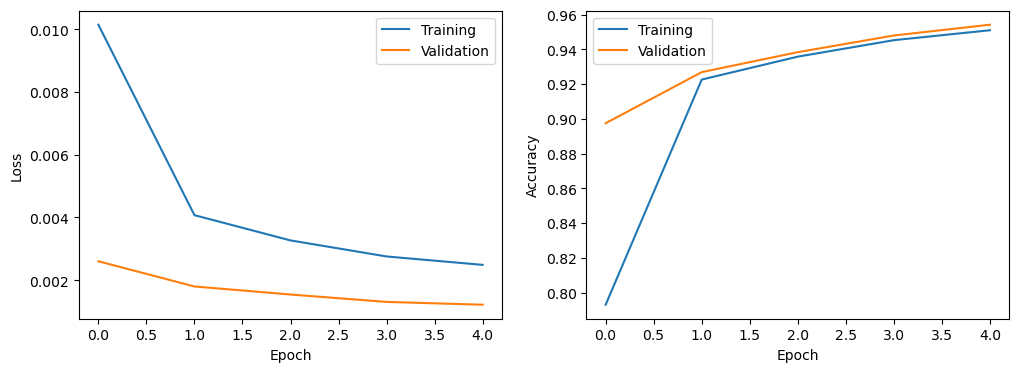

In [247]:
set_seed(SEED)
PATIENCE = 3
model = CNN(num_layers=3, num_channels=NUM_CHANNELS, num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
dataloaders = instantiate_dataloaders(
    mnist_train_split, mnist_val_split, mnist_test, BATCH_SIZE, NUM_WORKERS, SEED
)

best_model_state_dict = fit(
    model, dataloaders, criterion, optimizer, NUM_EPOCHS, PATIENCE, device=device
)

In [248]:
# load the model from state dict
model.load_state_dict(best_model_state_dict)

test_loss, test_acc = run_epoch(model, dataloaders["test"], criterion, train=False)
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

Test - loss: 0.0012, acc: 0.9537


# Summary
Great, so now we have a general training loop and know how to quickly define new models! Now let us sum up what we have learned during this journey:


**Reproducibility**: To make sure that your results are reproducible, you need to set the random seed using `torch.manual_seed()`. You might also need to set the python seed and the numpy random generator seed. Additional attention is needed when using the GPU (beyond the scope of this tutorial).

**Type annotations**: Type annotations are not necessary, but can be very helpful when working with Python and PyTorch. We also use the `beartype` decorator to make sure that our code is type-checked (meaning that the types are checked at runtime).

`torch.tensor`: PyTorch tensors work like Numpy arrays, but can remember gradients and be sent to the GPU.

`torch.nn`: Many useful layers are already implemented in this library, e.g. `nn.Linear` or `nn.Conv2d`.

- `torch.nn.functional`: Provides various useful functions (non stateful) for training neural networks, e.g. activation and loss functions.
- `torch.nn.Module`: Subclass from this to create a callable that acts like a function, but can remember state. It knows what `Parameter`s and submodules it contains and provides various functionality based on that.
- `torch.nn.Parameter`: Wraps a tensor and tells the containing Module that it needs updating during backpropagation.
- `torch.nn.Sequential`: Provides an easy way of defining purely stacked modules.
- `torch.nn.ModuleList`: Provides an easy way of defining a list of modules.


`torch.optim`: Optimizers such as `SGD` or `Adam`, which let you easily update and train the `Parameter`s inside the passed model.

`torch.utils.data.Dataset`: An abstract class for representing a dataset. Provides an easy way of loading and processing data. Any dataset should subclass this class and implement `__len__` and `__getitem__`. Tensors can be converted to datasets using `TensorDataset`.

`torch.utils.data.DataLoader`: Takes any `Dataset` and provides an iterator for returning mini-batches with various advanced functionality.

**GPU**: To use your GPU you need to move your model and each mini-batch to your GPU using `.to(device)`.

**Checkpointing**: To save and load your model's state use `torch.save` and `torch.load`.

Other useful libraries:
- `torchvision`: Provides various useful datasets, transforms and models for computer vision.

Optional:
- `jaxtyping`: Provides type annotations for PyTorch tensors, including shape and dtype information.